In [1]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame

import pickle


from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
f1 = open('customer_service_reps','rb')
csr = pickle.load(f1)
csr.head()

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN


In [3]:
f2 = open('engagement','rb')
engagement = pickle.load(f2)
engagement.head()

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0


In [4]:
f3 = open('subscribers','rb')
subscribers = pickle.load(f3)
subscribers.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0,0.0367,ar,False,False,NaN


In [5]:
advertising_spend = pd.read_excel('advertising_spend_data.xlsx')
advertising_spend.columns = advertising_spend.iloc[1]
advertising_spend = advertising_spend.drop([0,1])
advertising_spend.head()

1,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
2,2019-06-30 00:00:00,84800,75000,17300,21400,11900,10500,5900,6100
3,2019-07-31 00:00:00,60000,75600,17300,21300,12000,29800,6000,6600
4,2019-08-31 00:00:00,52300,76100,18100,21300,16300,65900,6200,6800
5,2019-09-30 00:00:00,49000,75800,18900,21300,16400,73700,6000,7400
6,2019-10-31 00:00:00,51300,76000,21000,21400,12200,32300,6700,7300


# Customer Segmentation

In [51]:
#subscribers['package_type'].value_counts() #3 types
#subscribers['preferred_genre'].value_counts() #5 types
#subscribers['intended_use'].value_counts()  #7 types
#subscribers['language'].value_counts() #1 types(discard)
#subscribers['country'].value_counts() #1 types(discard)

In [6]:
c_s = subscribers.loc[:,['subid','package_type','preferred_genre','intended_use','age','male_TF']]
#c_s #227628 rows

##### deal with missing value

In [7]:
null_num = c_s.isna().sum()
null_num

subid                  0
package_type       35574
preferred_genre    36326
intended_use        3549
age                35169
male_TF              269
dtype: int64

In [40]:
# method 1, drop all null 
#c_s_1 = c_s.dropna(subset = ['package_type'])
#c_s_dropnull #155836 rows, 71792 rows are dropped

# methos 2 ,use column mean to fill nan
#c_s_meannull = c_s.fillna(c_s.mean())
#c_s_meannull #227628  rows

In [8]:
# use missing to fill all nan value
c_s_1 = c_s.fillna('missing')
c_s_1 #227628 rows

#c_s_1['package_type'].value_counts()

,subid,package_type,preferred_genre,intended_use,age,male_TF
162502,21724479,economy,comedy,access to exclusive content,missing,False
380374,23383224,base,comedy,access to exclusive content,70.0,False
496617,26844789,enhanced,regional,replace OTT,25.0,True
356799,29417030,base,drama,replace OTT,30.0,False
681701,26723159,base,comedy,replace OTT,28.0,False
...,...,...,...,...,...,...
509326,21434712,enhanced,comedy,supplement OTT,38.0,False
229587,25843074,enhanced,comedy,replace OTT,49.0,False
281340,24799085,base,comedy,access to exclusive content,45.0,False
87198,21308040,base,comedy,access to exclusive content,missing,False


In [9]:
# but age need to do more,no one has 720 year old,use subscribers mean(which < 60) to fill nan and outlier
c_s_1['age'].value_counts()

missing              35169
50.0                  6355
40.0                  5509
60.0                  5221
48.0                  4651
                     ...  
675.0                    1
696.0                    1
717.0                    1
720.0                    1
56.86806589721665        1
Name: age, Length: 279, dtype: int64

In [11]:
subscirber_less_than_60 = subscribers.loc[subscribers['age'] <= 60] 
#subscirber_less_than_80 # 153846 rows
subscirber_less_than_80['age'].mean() # 41.88541129680826

41.88541129680826

In [12]:
# replace 42 to missing
age = c_s_1.loc[:,['subid','age']]
age_1 = age.replace('missing',42)
age_1

,subid,age
162502,21724479,42.0
380374,23383224,70.0
496617,26844789,25.0
356799,29417030,30.0
681701,26723159,28.0
...,...,...
509326,21434712,38.0
229587,25843074,49.0
281340,24799085,45.0
87198,21308040,42.0


In [13]:
# replace 42 to age > 60
age_1.loc[age_1['age'] > 60,'age'] = 42
age_1

,subid,age
162502,21724479,42.0
380374,23383224,42.0
496617,26844789,25.0
356799,29417030,30.0
681701,26723159,28.0
...,...,...
509326,21434712,38.0
229587,25843074,49.0
281340,24799085,45.0
87198,21308040,42.0


In [14]:
# merge age to c_s_1
c_s_2 = pd.merge(c_s_1,age_1,how = 'outer',on ='subid' )
c_s_2

,subid,package_type,preferred_genre,intended_use,age_x,male_TF,age_y
0,21724479,economy,comedy,access to exclusive content,missing,False,42.0
1,23383224,base,comedy,access to exclusive content,70.0,False,42.0
2,26844789,enhanced,regional,replace OTT,25.0,True,25.0
3,29417030,base,drama,replace OTT,30.0,False,30.0
4,26723159,base,comedy,replace OTT,28.0,False,28.0
...,...,...,...,...,...,...,...
227623,21434712,enhanced,comedy,supplement OTT,38.0,False,38.0
227624,25843074,enhanced,comedy,replace OTT,49.0,False,49.0
227625,24799085,base,comedy,access to exclusive content,45.0,False,45.0
227626,21308040,base,comedy,access to exclusive content,missing,False,42.0


In [15]:
# drop age_x and rename age_y
c_s_3 = c_s_2.drop(columns = ['age_x'])
c_s_3 = c_s_3.rename(columns = {'age_y':'age'})
c_s_3 # 6 columns

,subid,package_type,preferred_genre,intended_use,male_TF,age
0,21724479,economy,comedy,access to exclusive content,False,42.0
1,23383224,base,comedy,access to exclusive content,False,42.0
2,26844789,enhanced,regional,replace OTT,True,25.0
3,29417030,base,drama,replace OTT,False,30.0
4,26723159,base,comedy,replace OTT,False,28.0
...,...,...,...,...,...,...
227623,21434712,enhanced,comedy,supplement OTT,False,38.0
227624,25843074,enhanced,comedy,replace OTT,False,49.0
227625,24799085,base,comedy,access to exclusive content,False,45.0
227626,21308040,base,comedy,access to exclusive content,False,42.0


In [16]:
null_num_1 = c_s_3.isna().sum()
null_num_1

subid              0
package_type       0
preferred_genre    0
intended_use       0
male_TF            0
age                0
dtype: int64

##### get dummy

In [17]:
dummy_fields = ['package_type','preferred_genre','intended_use','male_TF']
for each in dummy_fields:
    dummies = pd.get_dummies(c_s_3.loc[:,each],prefix = each)
    c_s_3 = pd.concat([c_s_3,dummies], axis = 1)

c_s_3  # 27 columns

c_s_4 = c_s_3.drop(columns = ['subid','package_type','preferred_genre','intended_use','male_TF'])
c_s_4 # 22 columns



,age,package_type_base,package_type_economy,package_type_enhanced,package_type_missing,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_missing,preferred_genre_other,...,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_missing,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,male_TF_missing
0,42.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,42.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,25.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,30.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,28.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227623,38.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
227624,49.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
227625,45.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
227626,42.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 1. withought standalized

##### K-means

In [18]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=68)
    kmeans.fit(c_s_4)
    sse[k] = kmeans.inertia_ 

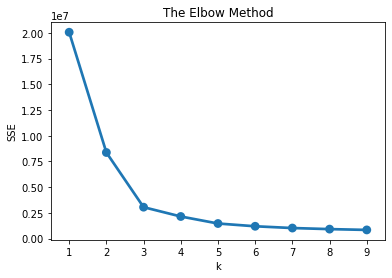

In [19]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
# k=3 is best

In [20]:
kmeans_3=KMeans(n_clusters=3).fit(c_s_4)
sse_3=kmeans_3.inertia_
y_kmeans_3=kmeans_3.predict(c_s_4)

In [21]:
kmeans_3.labels_

array([0, 0, 2, ..., 0, 0, 1])

##### see the clustering center

In [22]:
kmeans_3.cluster_centers_

array([[4.15636690e+01, 5.28280326e-01, 7.80405945e-02, 2.60540195e-01,
        1.33138884e-01, 5.74580470e-01, 2.12617868e-01, 2.74572479e-02,
        1.36119546e-01, 1.56065207e-02, 3.36183475e-02, 4.16621384e-01,
        1.88109318e-02, 4.88572798e-02, 5.22774493e-02, 1.36646955e-02,
        2.91273773e-02, 3.11027649e-01, 1.09613233e-01, 8.89315966e-01,
        1.08550424e-01, 2.13361036e-03],
       [5.37523623e+01, 4.66298689e-01, 9.34860964e-02, 2.44658808e-01,
        1.95556407e-01, 4.82230851e-01, 2.26706831e-01, 3.43368564e-02,
        1.99996518e-01, 1.93623653e-02, 3.73665790e-02, 3.74902056e-01,
        2.89913113e-02, 6.67409587e-02, 8.16458010e-02, 1.82305723e-02,
        4.55329003e-02, 2.62227717e-01, 1.21728683e-01, 8.74301336e-01,
        1.25663840e-01, 3.48243980e-05],
       [2.78274024e+01, 4.12255587e-01, 4.91377588e-02, 3.68111503e-01,
        1.70495151e-01, 5.66637814e-01, 1.60796325e-01, 2.21053332e-02,
        1.73247220e-01, 1.86874404e-02, 5.85258672e-02

##### see the clustering 

In [23]:
y_result=pd.DataFrame(y_kmeans_3)

In [24]:
result=pd.concat((pd.DataFrame(c_s_4,columns=c_s_4.columns),y_result),axis=1)

In [25]:
result.rename({0:'Cluster'},axis=1,inplace=True)

In [26]:
result.head()

,age,package_type_base,package_type_economy,package_type_enhanced,package_type_missing,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_missing,preferred_genre_other,...,intended_use_expand international access,intended_use_expand regional access,intended_use_missing,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,male_TF_missing,Cluster
0,42.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,42.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,25.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,2
3,30.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,2
4,28.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2


In [27]:
grouped_cluster=result.groupby(by=['Cluster']).sum()
grouped_cluster.T

Cluster,0,1,2
age,5.201278e+06,3.087052e+06,1.253819e+06
package_type_base,6.610900e+04,2.678000e+04,1.857500e+04
package_type_economy,9.766000e+03,5.369000e+03,2.214000e+03
package_type_enhanced,3.260400e+04,1.405100e+04,1.658600e+04
package_type_missing,1.666100e+04,1.123100e+04,7.682000e+03
preferred_genre_comedy,7.190300e+04,2.769500e+04,2.553100e+04
preferred_genre_drama,2.660700e+04,1.302000e+04,7.245000e+03
preferred_genre_international,3.436000e+03,1.972000e+03,9.960000e+02
preferred_genre_missing,1.703400e+04,1.148600e+04,7.806000e+03
preferred_genre_other,1.953000e+03,1.112000e+03,8.420000e+02


### 2. with standalized

In [28]:
scaler=MinMaxScaler()
scaler.fit(c_s_4)
c_s_4_norm=scaler.transform(c_s_4)
#c_s_4_norm

In [29]:
## with normalization
sse2 = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=68)
    kmeans.fit(c_s_4_norm)
    sse2[k] = kmeans.inertia_ 

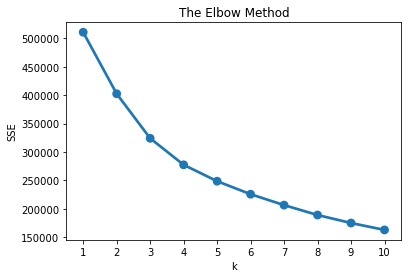

In [30]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse2.keys()), y=list(sse2.values()))
plt.show()

In [ ]:
# k = 5 is best

In [34]:
kmeans_5=KMeans(n_clusters=5).fit(c_s_4_norm)
sse_5=kmeans_5.inertia_
y_kmeans_5=kmeans_5.predict(c_s_4_norm)

In [35]:
kmeans_5.labels_

array([1, 1, 2, ..., 1, 1, 0])

##### see the clustering center

In [36]:
kmeans_5.cluster_centers_

array([[ 7.01010743e-01,  9.12830681e-01,  8.71693193e-02,
        -2.88657986e-15, -4.24660307e-15,  7.11073004e-01,
         1.74838790e-01,  3.78150510e-02,  1.35755497e-03,
         2.51147670e-02,  4.98008324e-02, -3.15858451e-14,
         5.00151832e-04,  1.41114267e-03,  1.55404319e-03,
         3.60823822e-03,  4.81574764e-02,  7.19182609e-01,
         2.25586339e-01,  8.91663541e-01,  1.07514781e-01,
         8.21678009e-04],
       [ 7.06104831e-01,  8.91803206e-01,  1.08196794e-01,
        -2.88657986e-15, -1.11022302e-14,  8.94137597e-01,
         3.88578059e-16,  4.13363284e-02,  9.68669589e-15,
         2.13398520e-02,  4.31862227e-02,  1.00000000e+00,
        -1.32879818e-15, -5.34294831e-16,  1.14491749e-15,
         1.71564152e-15, -3.50761087e-15, -1.44884105e-14,
        -1.22124533e-15,  8.94181642e-01,  1.04298802e-01,
         1.51955603e-03],
       [ 6.69755376e-01,  4.24660307e-14,  6.43929354e-15,
         1.00000000e+00, -2.85882429e-15,  7.87366046e-01,
    

##### see the clustering 

In [37]:
y_result=pd.DataFrame(y_kmeans_5)

In [38]:
result=pd.concat((pd.DataFrame(c_s_4_norm,columns=c_s_4.columns),y_result),axis=1)

In [39]:
result.rename({0:'Cluster'},axis=1,inplace=True)
result.head()

,age,package_type_base,package_type_economy,package_type_enhanced,package_type_missing,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_missing,preferred_genre_other,...,intended_use_expand international access,intended_use_expand regional access,intended_use_missing,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,male_TF_missing,Cluster
0,0.700000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.700000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,0.416667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
3,0.500000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,0.466667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [40]:
grouped_cluster=result.groupby(by=['Cluster']).mean()
grouped_cluster.T

Cluster,0,1,2,3,4
age,0.701011,0.706105,0.669755,0.707880,0.723766
package_type_base,0.912831,0.891803,0.000000,0.012302,0.581358
package_type_economy,0.087169,0.108197,0.000000,0.002189,0.223809
package_type_enhanced,0.000000,0.000000,1.000000,0.000471,0.194205
package_type_missing,0.000000,0.000000,0.000000,0.985039,0.000629
preferred_genre_comedy,0.711073,0.894138,0.787366,0.001330,0.000000
preferred_genre_drama,0.174839,0.000000,0.088691,0.000000,0.959411
preferred_genre_international,0.037815,0.041336,0.030686,0.000083,0.019935
preferred_genre_missing,0.001358,0.000000,0.003789,0.998393,0.000000
preferred_genre_other,0.025115,0.021340,0.021574,0.000111,0.009100


In [45]:
def K_mean_opt(df,k):
    kmeans=KMeans(n_clusters=k).fit(df)
    y_kmeans=kmeans.predict(df)
    y_result=pd.DataFrame(y_kmeans)
    result=pd.concat((pd.DataFrame(df,columns=c_s_4.columns),y_result),axis=1)
    result.rename({0:'Cluster'},axis=1,inplace=True)
    grouped_cluster=result.groupby(by=['Cluster']).mean()
    final_grouped=grouped_cluster.T
    return final_grouped

In [46]:
grouped_k5=K_mean_opt(c_s_4_norm,5)
grouped_k5

Cluster,0,1,2,3,4
age,0.721517,0.665342,0.707899,0.697888,0.698223
package_type_base,0.694864,0.000000,0.014311,0.612651,0.888408
package_type_economy,0.150296,0.000000,0.002229,0.087295,0.111592
package_type_enhanced,0.154340,1.000000,0.005009,0.300054,0.000000
package_type_missing,0.000500,0.000000,0.978451,0.000000,0.000000
preferred_genre_comedy,0.000000,0.741113,0.001321,0.878181,0.857580
preferred_genre_drama,0.995314,0.136970,0.000000,0.000000,0.000000
preferred_genre_international,0.002212,0.029288,0.000110,0.044737,0.048989
preferred_genre_missing,0.000000,0.001361,0.998349,0.000000,0.000000
preferred_genre_other,0.001404,0.022239,0.000138,0.023783,0.031323
